In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import mordred, mordred.descriptors
import counterstone as cs

IPythonConsole.ipython_useSVG = True
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#F3B562', '#6e5687', '#5C4B51']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)
toxdata = pd.read_csv('BBBP.csv')
toxdata = toxdata
toxdata.head()

/home/whitead/counterstone/counterstone/counterstone.py:106: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if preset is 'medium':
/home/whitead/counterstone/counterstone/counterstone.py:109: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif preset is 'narrow':
/home/whitead/counterstone/counterstone/counterstone.py:112: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif preset is 'wide':


,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [2]:
# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# the invalid molecules were None, so we'll just
# use the fact the None is False in Python
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]
try:
    raw_features = pd.read_pickle('raw_features.pb')
except FileNotFoundError as e:
    raw_features = calc.pandas(valid_mols, nproc=8)
    raw_features.to_pickle('raw_features.pb')

In [3]:
labels = toxdata[valid_mol_idx].p_np

In [4]:
fm = raw_features.mean()
fs = raw_features.std()
def feature_convert(f):
    f -= fm
    f /= fs
    return f

features = feature_convert(raw_features)

# we have some nans in features, likely because std was 0
features = features.values.astype(float)
features_select = np.all(np.isfinite(features), axis=0)
features = features[:, features_select]

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, shuffle=True)

clf = RandomForestClassifier(max_depth=8, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.914832285115304

In [6]:
def model_eval(smiles):
    molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    # input wrangling. Get some weird values from weird smiles
    raw_features = calc.pandas(molecules, nproc=8, quiet=True)
    features = feature_convert(raw_features)
    features = features.values.astype(float)
    features = features[:, features_select]
    labels = clf.predict(np.nan_to_num(features))
    return labels
    #return np.random.choice([True, False], size=labels.shape)
labels = model_eval(toxdata.iloc[valid_mol_idx].smiles.values[:100])

In [7]:
example_neg = toxdata.iloc[valid_mol_idx].smiles.values[np.argmin(labels)]
example_pos = toxdata.iloc[valid_mol_idx].smiles.values[np.argmax(labels)]
example_neg_y, example_pos_y = model_eval([example_neg, example_pos])
print('neg:', example_neg, '\npos:', example_pos)
print(example_neg_y, example_pos_y)

neg: Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[C@@H](N4C3=O)C(O)=O 
pos: [Cl].CC(C)NCC(O)COc1cccc2ccccc12
0 1


In [8]:
exps,space = cs.explain(example_neg, lambda sm, se: (model_eval(sm)- example_neg_y).astype(bool))

Round Complete with 1500
Round Complete with 1500
Adjusting max_k to 3
Starting with 2761 explanations


In [9]:
exps

[Explanation(smiles='Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[C@@H](N4C3=O)C(O)=O', selfies=None, similarity=1.0, index=0, position=array([-10.46940677,   2.06333091]), is_counter=True, is_base=True),
 Explanation(smiles='Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2C', selfies='', similarity=0.8, index=176, position=array([-8.0675186 , -0.22468236]), is_counter=True, is_base=False),
 Explanation(smiles='Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2F', selfies='', similarity=0.8, index=1678, position=array([-7.96627558, -0.23360419]), is_counter=True, is_base=False),
 Explanation(smiles='Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2C#[O+]', selfies='O+', similarity=0.7727272727272727, index=32, position=array([-7.42531255, -0.22463865]), is_counter=True, is_base=False),
 Explanation(smiles='Cc1onc(-c2ccccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)[S-]', selfies='S-', similarity=0.8809523809523809, index=179, position=array([-8.73396176,  0.86992174]), is_counter=False, is_ba

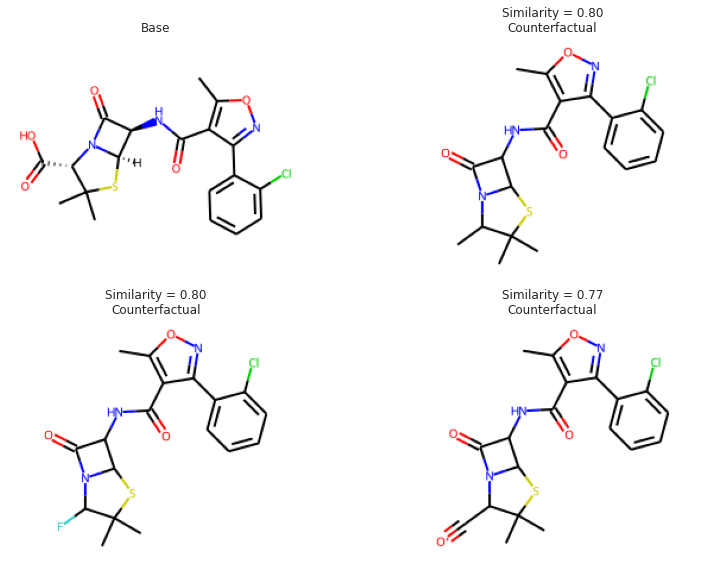

In [10]:
cs.plot_explanation(exps)

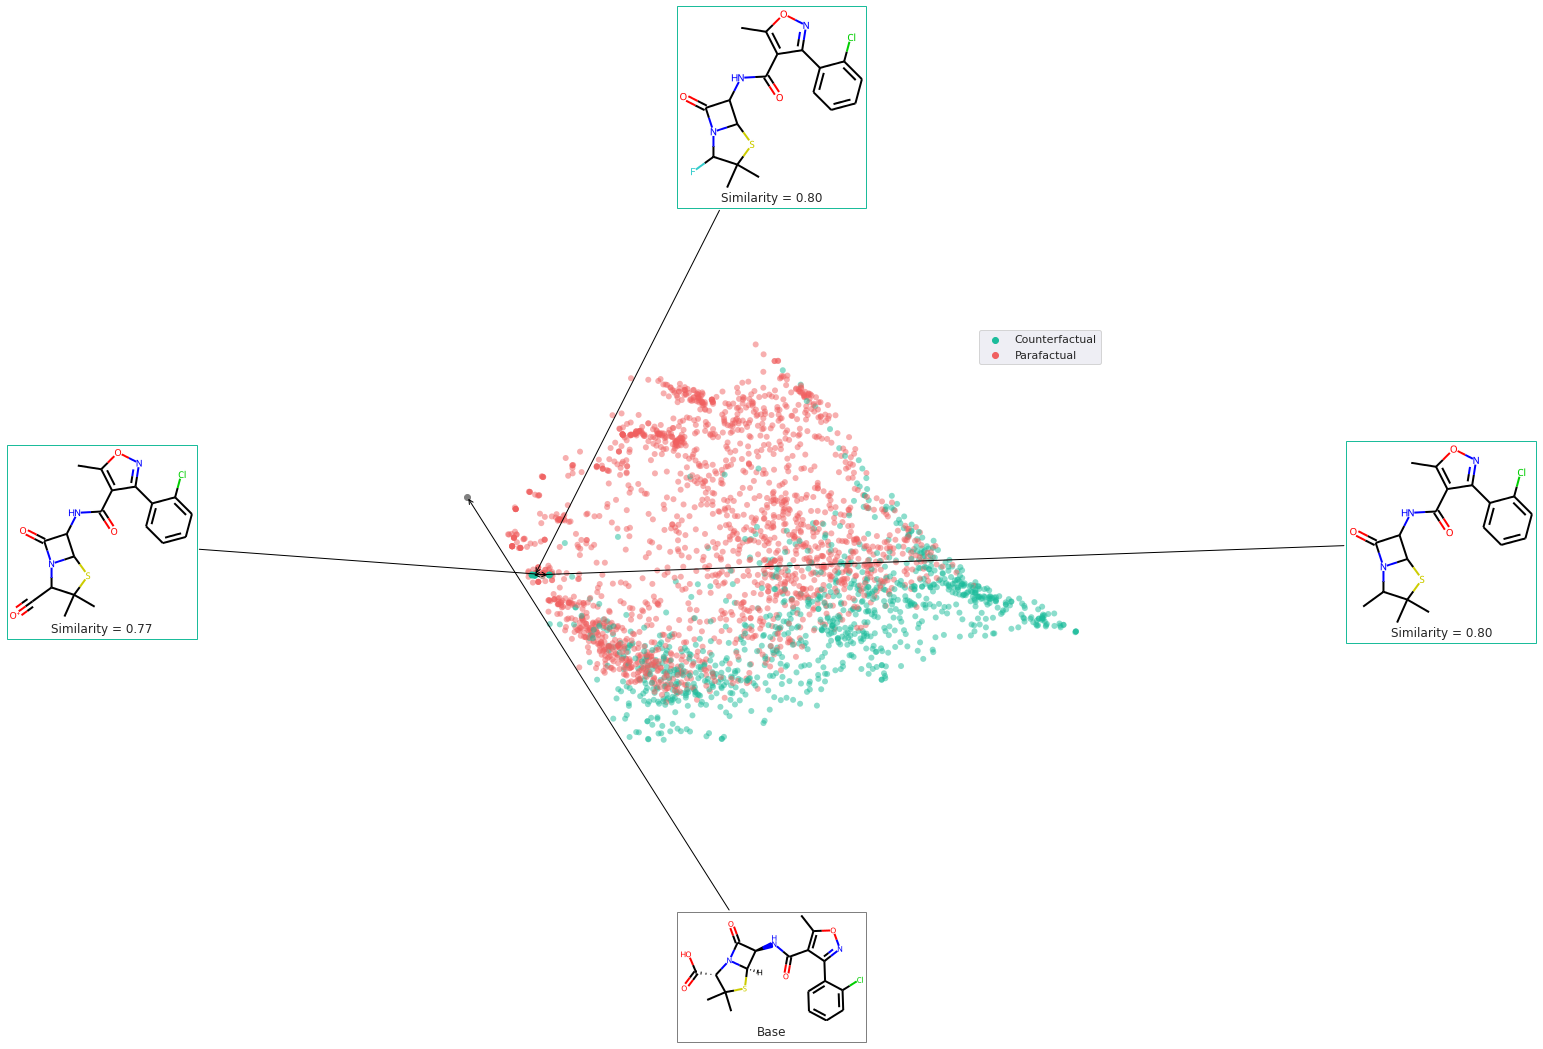

In [11]:
cs.plot_explanation(exps, space)